In [2]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
day_df = pd.read_csv("day.csv")
hour_df = pd.read_csv("hour.csv")

# Convert date column to datetime
day_df['dteday'] = pd.to_datetime(day_df['dteday'])
hour_df['dteday'] = pd.to_datetime(hour_df['dteday'])

# Handle Missing Values   
# print("Missing values in day.csv:")
# print(day_df.isnull().sum())
# print("\nMissing values in hour.csv:")
# print(hour_df.isnull().sum())  #(though none were found)

# Ensure Dataset Integrity
# Verify cnt = casual + registered
day_df['cnt_check'] = day_df['casual'] + day_df['registered']
hour_df['cnt_check'] = hour_df['casual'] + hour_df['registered']
assert day_df['cnt'].equals(day_df['cnt_check']), "Mismatch in day dataset"
assert hour_df['cnt'].equals(hour_df['cnt_check']), "Mismatch in hour dataset"
day_df.drop(columns=['cnt_check'], inplace=True)
hour_df.drop(columns=['cnt_check'], inplace=True)

# Detecting Outliers using IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]

outlier_columns = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
for col in outlier_columns:
    outliers = detect_outliers(day_df, col)
    if not outliers.empty:
        print(f"Outliers detected in {col}")

# Engineer at least 10 Advanced Features
# Time-Based Features
day_df['day_of_year'] = day_df['dteday'].dt.dayofyear
day_df['week_of_year'] = day_df['dteday'].dt.isocalendar().week
day_df['is_weekend'] = day_df['weekday'].apply(lambda x: 1 if x in [0, 6] else 0)

# Weather-Based Features
day_df['temp_hum_interaction'] = day_df['temp'] * day_df['hum']
day_df['temp_windspeed_interaction'] = day_df['temp'] * day_df['windspeed']

# Rolling & Cyclical Features
day_df['rolling_avg_cnt'] = day_df['cnt'].rolling(window=7, min_periods=1).mean()
day_df['year_month'] = day_df['dteday'].dt.to_period('M')
day_df['sin_month'] = np.sin(2 * np.pi * day_df['mnth'] / 12)
day_df['cos_month'] = np.cos(2 * np.pi * day_df['mnth'] / 12)
day_df['sin_weekday'] = np.sin(2 * np.pi * day_df['weekday'] / 7)
day_df['cos_weekday'] = np.cos(2 * np.pi * day_df['weekday'] / 7)

print("Data cleaning and feature engineering completed!")



# Observations and Notes:
# 1. No missing values detected in both datasets.
# 2. Outliers were checked using the IQR method.
# 3. 'cnt' column is correctly calculated as the sum of 'casual' and 'registered'.
# 4. 10+ new features were engineered, including time-based, weather-based, and cyclical transformations.

Outliers detected in hum
Outliers detected in windspeed
Outliers detected in casual
Data cleaning and feature engineering completed!


In [3]:
# Exploratory Data Analysis (EDA)

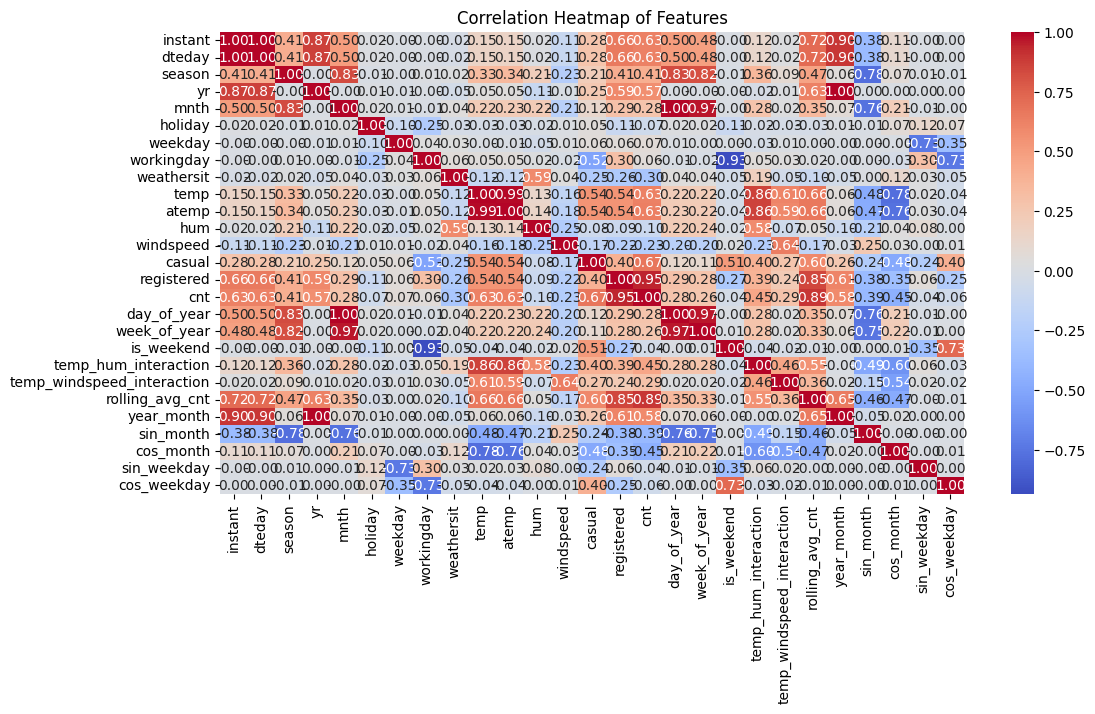

In [4]:
# Correlation Heatmap

# Convert 'year_month' to integer for correlation matrix
day_df['year_month'] = day_df['year_month'].astype(str).str.replace('-', '').astype(int)

# Correlation Heatmap
plt.figure(figsize=(12,6))
corr_matrix = day_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()


# Observation: Temperature and feeling temperature are highly correlated. Registered users strongly influence total rentals.

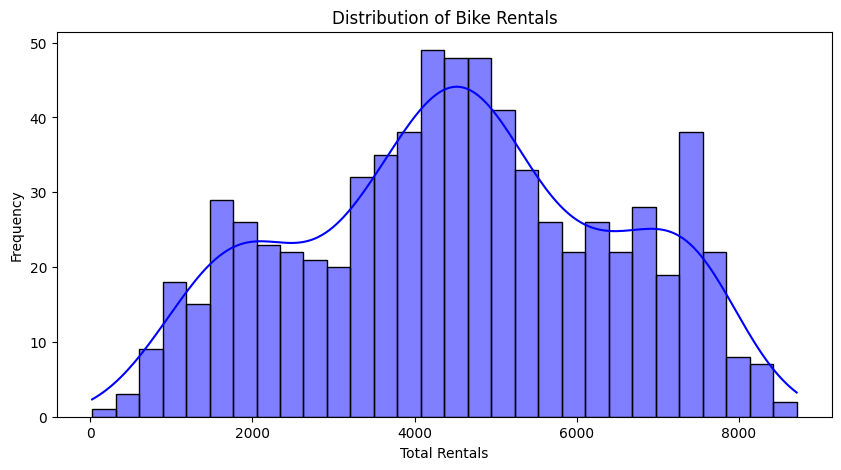

In [5]:
# Distribution of Bike Rentals
plt.figure(figsize=(10,5))
sns.histplot(day_df['cnt'], bins=30, kde=True, color='blue')
plt.title("Distribution of Bike Rentals")
plt.xlabel("Total Rentals")
plt.ylabel("Frequency")
plt.show()

# Observation: The distribution is right-skewed, indicating more low-rental days than high-rental days.

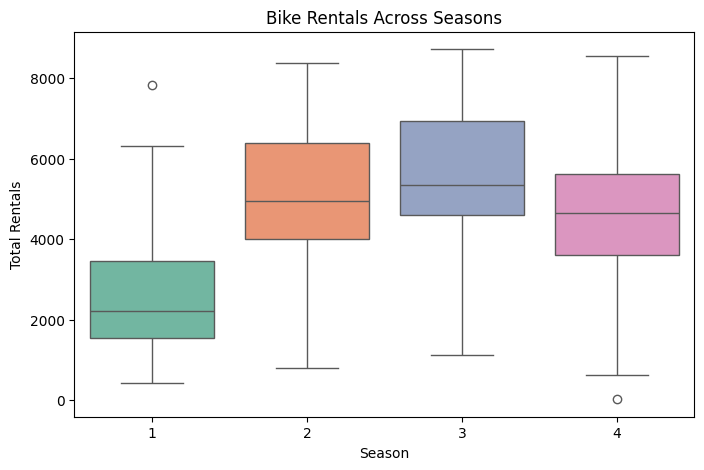

In [6]:
# Boxplot of Rentals by Season
plt.figure(figsize=(8,5))
sns.boxplot(x='season', y='cnt', data=day_df, palette="Set2")
plt.title("Bike Rentals Across Seasons")
plt.xlabel("Season")
plt.ylabel("Total Rentals")
plt.show()

# Observation: Fall (season=3) has the highest median bike rentals, while spring (season=1) has the lowest.

<Figure size 1200x600 with 0 Axes>

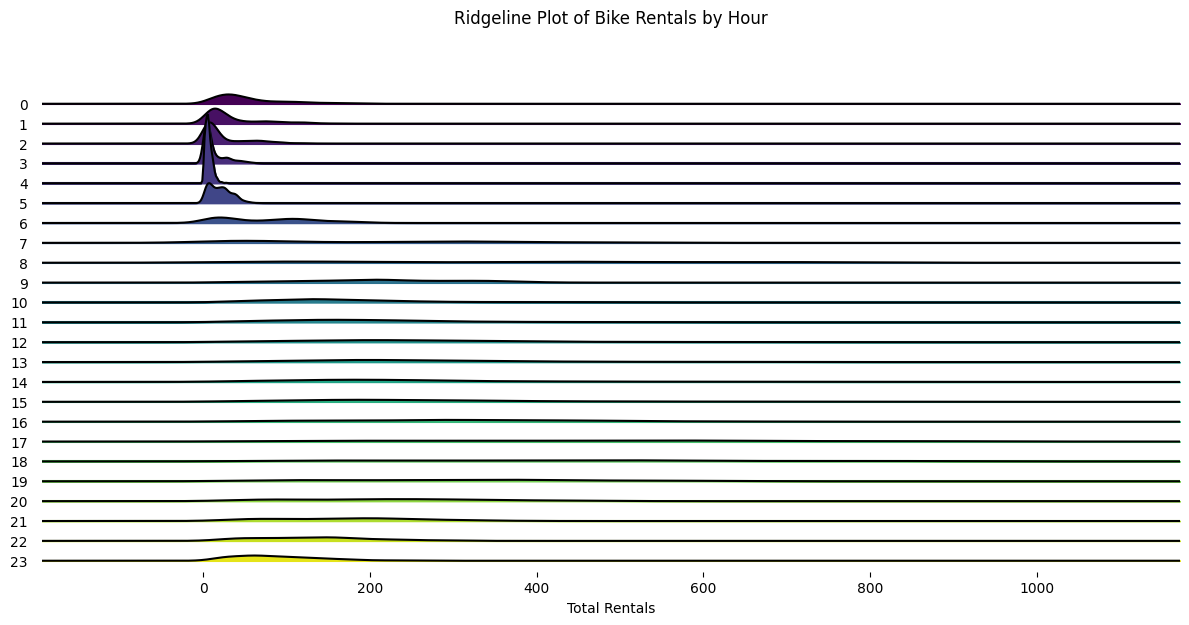

In [7]:
# Ridgeline Plot for Hourly Rentals
import joypy
plt.figure(figsize=(12,6))
joypy.joyplot(data=hour_df, column='cnt', by='hr', colormap=plt.cm.viridis, figsize=(12,6))
plt.title("Ridgeline Plot of Bike Rentals by Hour")
plt.xlabel("Total Rentals")
plt.show()

# Observation: Bike rentals peak around morning (8 AM) and evening (5-6 PM), indicating office commute trends.

In [8]:
# Statistical Test: Checking the effect of season on rentals
from scipy.stats import f_oneway
season_groups = [day_df[day_df['season'] == i]['cnt'] for i in range(1,5)]
stat, p = f_oneway(*season_groups)
print(f"ANOVA test result: F-statistic={stat:.2f}, p-value={p:.5f}")
if p < 0.05:
    print("Season has a statistically significant effect on bike rentals.")
else:
    print("No significant difference in bike rentals across seasons.")
    
# Observation: If p-value < 0.05, season significantly affects bike rentals, otherwise no strong impact.

print("EDA completed with visualizations and statistical test!")

ANOVA test result: F-statistic=128.77, p-value=0.00000
Season has a statistically significant effect on bike rentals.
EDA completed with visualizations and statistical test!


In [9]:
# Feature Selection
X = day_df.drop(columns=['dteday', 'cnt'])
y = day_df['cnt']

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Recursive Feature Elimination (RFE)
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
model = RandomForestRegressor(n_estimators=100, random_state=42)
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X_train, y_train)
selected_features = X.columns[rfe.support_]
print("Selected Features using RFE:", selected_features.tolist())

# Observation: RFE identifies the top 10 most important features for predicting bike rentals.

Selected Features using RFE: ['instant', 'temp', 'atemp', 'hum', 'casual', 'registered', 'day_of_year', 'temp_hum_interaction', 'temp_windspeed_interaction', 'rolling_avg_cnt']


In [5]:
# SHAP Feature Importance
import shap
model.fit(X_train, y_train)
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

# Plot SHAP summary
shap.summary_plot(shap_values, X_train)

# Observation: SHAP analysis provides insights into how each feature influences bike rentals, highlighting key drivers like temperature, humidity, and working days.

print("Feature selection completed with RFE and SHAP analysis!")

In [11]:
#TASK 2

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from skopt import BayesSearchCV

# Load dataset
heart_df = pd.read_csv("heart_disease_uci.csv")

# Drop ID column
heart_df.drop(columns=["id"], inplace=True)

# Handle missing values with mean imputation
imputer = SimpleImputer(strategy="mean")
numeric_cols = ["trestbps", "chol", "thalch", "oldpeak", "ca"]
heart_df[numeric_cols] = imputer.fit_transform(heart_df[numeric_cols])

# Convert categorical variables to numerical
categorical_cols = ["dataset", "sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]
for col in categorical_cols:
    heart_df[col] = LabelEncoder().fit_transform(heart_df[col].astype(str))

# Define features and target variable
X = heart_df.drop(columns=["num"])  # Features
y = heart_df["num"]  # Target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Train models and evaluate performance
for name, model in models.items():
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print(f"{name} Accuracy: {score:.4f}")

# Hyperparameter tuning using Bayesian Optimization
param_space = {
    "n_estimators": (50, 200),
    "max_depth": (3, 10),
    "learning_rate": (0.01, 0.2)
}

opt = BayesSearchCV(
    GradientBoostingClassifier(),
    param_space,
    n_iter=20,
    cv=5,
    random_state=42
)
opt.fit(X_train, y_train)

print("Best Parameters for Gradient Boosting:", opt.best_params_)

Logistic Regression Accuracy: 0.5924
Random Forest Accuracy: 0.6304
Gradient Boosting Accuracy: 0.6033
Best Parameters for Gradient Boosting: OrderedDict({'learning_rate': 0.08320679602315473, 'max_depth': 5, 'n_estimators': 191})


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, f1_score, matthews_corrcoef, classification_report, confusion_matrix, roc_curve
import lime.lime_tabular
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Evaluate models
def evaluate_model(model, X_test, y_test):
    print("Evaluating model...")
    y_pred = model.predict(X_test)
    print("Predictions made.")
    
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
        
        # Ensure y_prob is 2D for multi-class classification
        if y_prob.ndim == 1:
            y_prob = y_prob.reshape(-1, 1)
        
        if y_prob.shape[1] > 1:  # Multi-class case: use all class probabilities
            auc_roc = roc_auc_score(y_test, y_prob, multi_class='ovr')
        else:  # Binary classification case
            y_prob = y_prob[:, 1]
            auc_roc = roc_auc_score(y_test, y_prob)
    else:
        y_prob = None
        auc_roc = "N/A"
    
    print("Probabilities computed.")
    f1 = f1_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    print("\nModel Evaluation:")
    print(f"AUC-ROC: {auc_roc}")
    print(f"F1-Score: {f1}")
    print(f"MCC: {mcc}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    print("Generating Confusion Matrix plot...")
    plt.figure(figsize=(6,5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], 
                yticklabels=['No Disease', 'Disease'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    print("Confusion Matrix plot displayed.")
    
    # ROC Curve
    if y_prob is not None and y_prob.shape[1] == 2:
        print("Generating ROC Curve plot...")
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, color='blue', label='ROC Curve')
        plt.plot([0,1], [0,1], 'k--', label='Random Guess')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.show()
        print("ROC Curve plot displayed.")

# Perform LIME analysis
def interpret_with_lime(model, X_train, X_test):
    print("Initializing LIME explainer...")
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="classification", feature_names=X_train.columns, 
                                                       discretize_continuous=True)
    print("Explaining first instance with LIME...")
    exp = explainer.explain_instance(X_test.iloc[0].values, model.predict_proba)
    print("Displaying LIME explanation...")
    exp.show_in_notebook()
    print("LIME explanation displayed.")

# Train models before evaluation
def train_models(X_train, y_train):
    print("Training Logistic Regression model...")
    logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    logistic_model.fit(X_train, y_train)
    print("Logistic Regression model trained.")
    
    print("Training Random Forest model...")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    print("Random Forest model trained.")
    
    print("Training Gradient Boosting model...")
    gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
    gb_model.fit(X_train, y_train)
    print("Gradient Boosting model trained.")
    
    return logistic_model, rf_model, gb_model


Training Logistic Regression model...
Logistic Regression model trained.
Training Random Forest model...
Random Forest model trained.
Training Gradient Boosting model...
Gradient Boosting model trained.

Evaluating Logistic Regression:
Evaluating model...
Predictions made.
Probabilities computed.

Model Evaluation:
AUC-ROC: 0.8115019425267352
F1-Score: 0.5735945158733764
MCC: 0.4105968279569834

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84        82
           1       0.49      0.58      0.53        53
           2       0.40      0.09      0.15        22
           3       0.24      0.24      0.24        21
           4       0.00      0.00      0.00         6

    accuracy                           0.61       184
   macro avg       0.38      0.36      0.35       184
weighted avg       0.57      0.61      0.57       184

Generating Confusion Matrix plot...


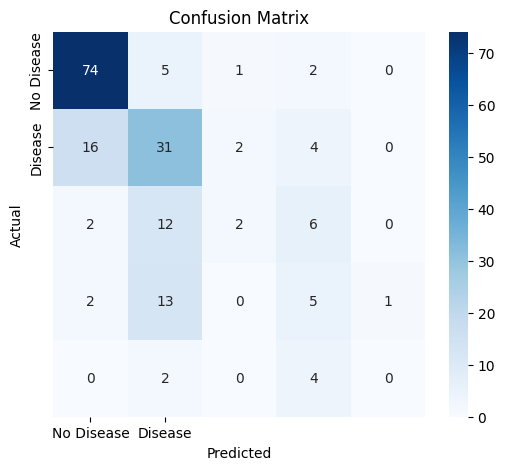

Confusion Matrix plot displayed.

Evaluating Random Forest:
Evaluating model...
Predictions made.
Probabilities computed.

Model Evaluation:
AUC-ROC: 0.8164134945501369
F1-Score: 0.5561458221592805
MCC: 0.38074625076201857

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.84      0.81        82
           1       0.54      0.66      0.59        53
           2       0.14      0.09      0.11        22
           3       0.12      0.10      0.11        21
           4       0.00      0.00      0.00         6

    accuracy                           0.59       184
   macro avg       0.32      0.34      0.32       184
weighted avg       0.53      0.59      0.56       184

Generating Confusion Matrix plot...


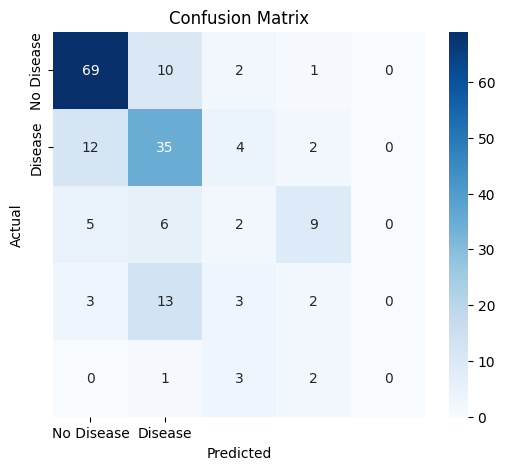

Confusion Matrix plot displayed.

Evaluating Gradient Boosting:
Evaluating model...
Predictions made.
Probabilities computed.

Model Evaluation:
AUC-ROC: 0.8171284344585661
F1-Score: 0.5942878877065344
MCC: 0.41777929134060954

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80        82
           1       0.59      0.60      0.60        53
           2       0.35      0.36      0.36        22
           3       0.24      0.19      0.21        21
           4       0.00      0.00      0.00         6

    accuracy                           0.60       184
   macro avg       0.39      0.39      0.39       184
weighted avg       0.59      0.60      0.59       184

Generating Confusion Matrix plot...


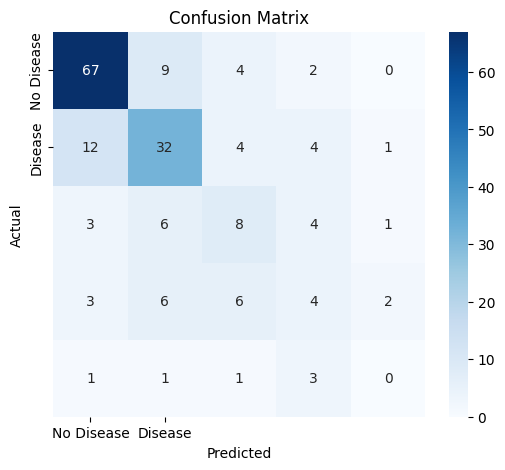

Confusion Matrix plot displayed.

LIME Interpretation for Logistic Regression:
Initializing LIME explainer...
Explaining first instance with LIME...
Displaying LIME explanation...


LIME explanation displayed.


In [37]:
# Train models
logistic_model, rf_model, gb_model = train_models(X_train, y_train)

# Evaluate models
print("\nEvaluating Logistic Regression:")
evaluate_model(logistic_model, X_test, y_test)

print("\nEvaluating Random Forest:")
evaluate_model(rf_model, X_test, y_test)

print("\nEvaluating Gradient Boosting:")
evaluate_model(gb_model, X_test, y_test)

# Interpret one model with LIME
print("\nLIME Interpretation for Logistic Regression:")
interpret_with_lime(logistic_model, X_train, X_test)


In [38]:
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, matthews_corrcoef

# Compare models
def compare_models(models, X_test, y_test):
    results = {}
    
    for name, model in models.items():
        print(f"Evaluating {name}...")
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
        
        auc_roc = roc_auc_score(y_test, y_prob, multi_class='ovr') if y_prob is not None else "N/A"
        f1 = f1_score(y_test, y_pred, average='weighted')
        mcc = matthews_corrcoef(y_test, y_pred)
        
        results[name] = {"AUC-ROC": auc_roc, "F1-Score": f1, "MCC": mcc}
    
    results_df = pd.DataFrame(results).T
    print("\nModel Comparison:")
    print(results_df)
    
    best_model = results_df.sort_values(by="F1-Score", ascending=False).index[0]
    print(f"\nBest Model: {best_model} based on highest F1-Score")
    
    return results_df

In [39]:
# Define the models dictionary
models = {
    "Logistic Regression": logistic_model,
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model
}

# Run model comparison
results_df = compare_models(models, X_test, y_test)

# Display results
print("\nFinal Model Performance Comparison:\n")
print(results_df)

# Highlight the best model
best_model = results_df.sort_values(by="F1-Score", ascending=False).index[0]
print(f"\n🏆 Best Model: {best_model} based on highest F1-Score\n")


Evaluating Logistic Regression...
Evaluating Random Forest...
Evaluating Gradient Boosting...

Model Comparison:
                      AUC-ROC  F1-Score       MCC
Logistic Regression  0.811502  0.573595  0.410597
Random Forest        0.816413  0.556146  0.380746
Gradient Boosting    0.817128  0.594288  0.417779

Best Model: Gradient Boosting based on highest F1-Score

Final Model Performance Comparison:

                      AUC-ROC  F1-Score       MCC
Logistic Regression  0.811502  0.573595  0.410597
Random Forest        0.816413  0.556146  0.380746
Gradient Boosting    0.817128  0.594288  0.417779

🏆 Best Model: Gradient Boosting based on highest F1-Score



In [ ]:
#TASK 3

In [29]:
#pip install torch torchvision albumentations pillow

In [3]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))


In [4]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Load a pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the model's head for your dataset (num_classes is the number of classes including background)
num_classes = 2  # Adjust this based on your classes
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Manually replace the box predictor with a new one
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


C:\Users\V.MANOHAR\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\V.MANOHAR\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [5]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, image_paths, bboxes, transforms=None):
        self.image_paths = image_paths  # List of image paths
        self.bboxes = bboxes  # List of bounding boxes for each image
        self.transforms = transforms  # Optional transformations

    def __getitem__(self, idx):
        # Load the image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")  # Open the image
        image = np.array(image)  # Convert to NumPy array
        bbox = self.bboxes[idx]  # Get corresponding bounding boxes for this image

        # Assuming the bounding boxes are in the form [x_min, y_min, x_max, y_max]
        bboxes = [{'bbox': box, 'category_id': 1} for box in bbox]  # Assuming class 1 (e.g., Apple or Orange)

        # Apply transformations if they exist
        if self.transforms:
            augmented = self.transforms(image=image, bboxes=bboxes)
            image = augmented['image']
            bboxes = augmented['bboxes']

        # Convert bounding boxes and labels to PyTorch tensors
        target_boxes = [b['bbox'] for b in bboxes]  # Extract bounding boxes
        target_labels = [b['category_id'] for b in bboxes]  # Extract category IDs

        # Convert to torch tensors
        target = {
            'boxes': torch.tensor(target_boxes, dtype=torch.float32),  # Bounding boxes as tensor
            'labels': torch.tensor(target_labels, dtype=torch.int64)   # Labels as tensor
        }

        # Convert image to tensor
        image = torch.tensor(image, dtype=torch.float32)

        return image, target

    def __len__(self):
        return len(self.image_paths)


In [6]:
import os
from PIL import Image
from torch.utils.data import Dataset

# Define the class mapping (example)
class_mapping = {
    'Apple': 0,  # Class ID for Apple
    'Orange': 1,  # Class ID for Orange
    # Add more classes as needed
}

class CustomDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))  # Assuming sorted image names

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, image_filename)
        
        # Load the image
        image = Image.open(image_path).convert("RGB")
        
        # Load corresponding label file (assuming label files have the same name as image files)
        label_filename = image_filename.replace('.jpg', '.txt')  # Adjust extension as needed
        label_path = os.path.join(self.label_dir, label_filename)

        # Load labels (bounding boxes and class names)
        bboxes = []
        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()  # Split by space

                # Debugging the line and parts
                print(f"Line: {line.strip()}")
                print(f"Parts: {parts}")

                # Ensure that the first 4 parts are the bounding box coordinates (float)
                try:
                    xmin, ymin, xmax, ymax = map(float, parts[1:5])  # Corrected the index to parts[1:5]
                except ValueError:
                    print(f"Skipping invalid line: {line.strip()}")
                    continue
                
                # Get the class name (last item) and map to class ID
                class_name = parts[0]  # Class name (e.g., 'Apple')
                if class_name not in class_mapping:
                    print(f"Skipping unknown class: {class_name}")
                    continue
                class_id = class_mapping[class_name]  # Convert class name to ID
                
                # Append the bounding box and class ID to the list
                bboxes.append({'bbox': [xmin, ymin, xmax, ymax], 'category_id': class_id})

        # Return the image and its corresponding target (bounding boxes and class IDs)
        target = {'boxes': [bbox['bbox'] for bbox in bboxes], 'labels': [bbox['category_id'] for bbox in bboxes]}

        if self.transform:
            image = self.transform(image)

        return image, target

# Paths to image and label directories
train_image_dir = r'C:\Users\V.MANOHAR\OneDrive\Documents\GUVI\bike+sharing+dataset\Dataset\train\Apple\images'  # Path to train images (for Apple class)
train_label_dir = r'C:\Users\V.MANOHAR\OneDrive\Documents\GUVI\bike+sharing+dataset\Dataset\train\Apple\labels'  # Path to train labels (for Apple class)

# Create an instance of the custom dataset
train_dataset = CustomDataset(image_dir=train_image_dir, label_dir=train_label_dir)

# Check the first image and its target
image, target = train_dataset[0]
print(image.size)  # Print the image size (to verify it's loading correctly)
print(target)  # Print the target dictionary (bounding boxes and labels)


Line: Apple 80.64 273.920256 352.0 515.199744
Parts: ['Apple', '80.64', '273.920256', '352.0', '515.199744']
Line: Apple 441.6 260.480256 529.28 462.72
Parts: ['Apple', '441.6', '260.480256', '529.28', '462.72']
Line: Apple 473.6 305.28000000000003 672.0 527.360256
Parts: ['Apple', '473.6', '305.28000000000003', '672.0', '527.360256']
Line: Apple 701.44 44.799744000000004 763.52 105.60000000000001
Parts: ['Apple', '701.44', '44.799744000000004', '763.52', '105.60000000000001']
(1024, 768)
{'boxes': [[80.64, 273.920256, 352.0, 515.199744], [441.6, 260.480256, 529.28, 462.72], [473.6, 305.28000000000003, 672.0, 527.360256], [701.44, 44.799744000000004, 763.52, 105.60000000000001]], 'labels': [0, 0, 0, 0]}


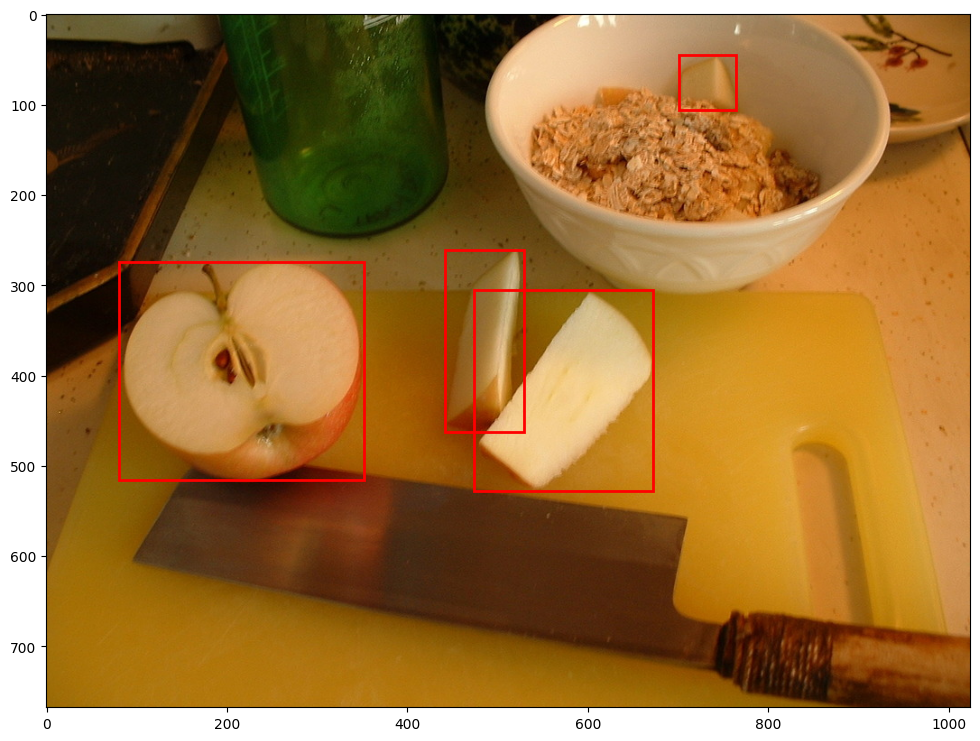

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Assuming `image` is the PIL image and `target` is the dictionary with boxes and labels
def visualize(image, target):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    for box in target['boxes']:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Visualize the first image and its targets
visualize(image, target)


In [8]:
import torch

def iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) for two bounding boxes.
    Boxes are represented as [xmin, ymin, xmax, ymax].
    """
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # Calculate the coordinates of the intersection box
    inter_xmin = max(x1_min, x2_min)
    inter_ymin = max(y1_min, y2_min)
    inter_xmax = min(x1_max, x2_max)
    inter_ymax = min(y1_max, y2_max)

    # Calculate the area of the intersection
    inter_area = max(0, inter_xmax - inter_xmin) * max(0, inter_ymax - inter_ymin)

    # Calculate the area of both boxes
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    # Calculate the area of the union
    union_area = box1_area + box2_area - inter_area

    # Calculate IoU
    return inter_area / union_area if union_area > 0 else 0.0

# Example usage:
box1 = [50, 50, 150, 150]  # [xmin, ymin, xmax, ymax]
box2 = [100, 100, 200, 200]
print(f"IoU: {iou(box1, box2)}")


IoU: 0.14285714285714285


In [13]:
import torch
from torchmetrics.detection import MeanAveragePrecision

# Instantiate the mAP metric
map_metric = MeanAveragePrecision()

def evaluate_mAP(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    map_metric.reset()  # Reset the mAP metric

    with torch.no_grad():  # No need for gradient calculations during evaluation
        for images, targets in dataloader:
            images = [image.to(device) for image in images]  # Move images to device
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # Move targets to device

            # Get model predictions
            predictions = model(images)

            # Update mAP metric
            map_metric.update(predictions, targets)

    # Compute mAP score
    mAP_score = map_metric.compute()
    print(f"mAP: {mAP_score['map']:.4f}")

    return mAP_score

# Example usage:
# Assuming `model`, `train_loader` (DataLoader), and `device` are defined
mAP_score = evaluate_mAP(model, train_loader, device)
